# exp004
catboost

In [27]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
from catboost import CatBoost, Pool

import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
@dataclass
class Cfg:
    mode = "local_cv" # "local_cv" or "kaggle_inf" 
    exp_name = "exp002"
    input_dir = "/mnt/predict-student-performance-from-game-play/input/"
    output_dir = "/mnt/predict-student-performance-from-game-play/output/"
    prep_dir = "/mnt/predict-student-performance-from-game-play/prep/"
    seed = 42
    n_splits = 5
    best_threshold = 0.6 # local_cvの結果を入れる
cfg = Cfg()

if cfg.mode == "local_cv":
    os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
    os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name, "cache"), exist_ok=True)

elif cfg.mode == "kaggle_inf":
    import jo_wilder

In [29]:
params = {
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'learning_rate': 0.1,
    'num_boost_round': 9999,
    'random_seed': cfg.seed,
    "od_type": "Iter"
} 

In [30]:
event_name_list = [
    'cutscene_click', 'person_click', 'navigate_click',
    'observation_click', 'notification_click', 'object_click',
    'object_hover', 'map_hover', 'map_click', 'checkpoint',
    'notebook_click'
]

name_list = [
    'basic', 'undefined', 'close', 'open', 'prev', 'next'
]

In [31]:
def transform_labels_df(labels_):
    """
    labelsデータを整形する
    """
    labels = labels_.copy()
    labels["question"] = labels["session_id"].apply(lambda x: x.split("_")[1].replace("q", "")).astype(int)
    labels["session_id"] = labels["session_id"].apply(lambda x: x.split("_")[0]).astype(int)
    
    # trainの特徴量と結合するためにquestionに対応するlabel_groupを列として設けておく
    labels["level_group"] = ""
    labels.loc[labels["question"]<=3, "level_group"] = "0-4"
    labels.loc[(labels["question"]>=4)&(labels["question"]<=13), "level_group"] = "5-12"
    labels.loc[labels["question"]>=14, "level_group"] = "13-22"

    return labels

In [32]:
class Features:
    def __init__(self, sessions):
        self.sessions = sessions.copy()
        self.features = sessions[["session_id", "level_group"]].drop_duplicates().copy()

    def _lg_record_cnt(self):
        add_features = self.sessions.groupby(["session_id", "level_group"])["index"].count().reset_index().rename(columns={"index":"lg_record_cnt"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _lg_event_name_record_cnt(self):
        add_features = self.sessions.groupby(["session_id", "level_group", "event_name"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for event in event_name_list:
            new_col = f"lg_{event}_record_cnt"
            tmp = add_features[add_features["event_name"]==event][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _lg_name_record_cnt(self):
        add_features = self.sessions.groupby(["session_id", "level_group", "name"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for name in name_list:
            new_col = f"lg_{name}_record_cnt"
            tmp = add_features[add_features["name"]==name][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _lg_elapsed_time(self):
        add_features = self.sessions.groupby(["session_id", "level_group"])["elapsed_time"].agg([max,min]).reset_index()
        add_features["lg_elapsed_time"] = add_features["max"] - add_features["min"]
        add_features = add_features[["session_id", "level_group", "lg_elapsed_time"]].copy()
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _lg_coor_mean(self):
        add_features = self.sessions.groupby(["session_id", "level_group"])[["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]].mean().reset_index()
        add_features = add_features.rename(columns={"room_coor_x":"lg_room_coor_x_mean", "room_coor_y":"lg_room_coor_y_mean", "screen_coor_x":"lg_screen_coor_x_mean", "screen_coor_y":"lg_screen_coor_y_mean"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def get_features(self):
        self._lg_record_cnt()
        self._lg_event_name_record_cnt()
        self._lg_name_record_cnt()
        self._lg_elapsed_time()
        self._lg_coor_mean()
        return self.features

In [33]:
def calc_metrics(oof):
    # find best th
    scores = []; thresholds = []
    best_score = 0; best_threshold = 0

    for threshold in np.arange(0.4,0.81,0.01):
        preds = (oof["pred"].values>threshold).astype(int)
        m = f1_score(oof["correct"].values, preds, average='macro')   
        scores.append(m)
        thresholds.append(threshold)
        if m>best_score:
            best_score = m
            best_threshold = threshold
    print("best_score", format(best_score, ".6f"))
    print("best_threshold", format(best_threshold, ".3f"))

    # Q別スコア
    print("---"*10)
    for q in range(18):
        q = q + 1
        preds = (oof[oof["question"]==q]["pred"].values>threshold).astype(int)
        m = f1_score(oof[oof["question"]==q]["correct"].values, preds, average='macro')
        print(f"Q{q} : F1 = {format(m, '.6f')}")
    return best_threshold

In [34]:
def get_train_data(sessions, labels):
    # labelデータの整形
    labels = transform_labels_df(labels)

    # 特徴量生成
    feat = Features(sessions)
    features = feat.get_features()
    
    train = features.merge(labels, on=["session_id", "level_group"], how="left")
    train["level_group"] = train["level_group"].map({"0-4":0, "5-12":1, "13-22":2}).astype(str)
    train["question"] = train["question"].astype(str)

    return train

In [35]:
def run_train():
    # データ読み込み
    train_sessions = pd.read_csv(cfg.input_dir + "train.csv")
    labels = pd.read_csv(cfg.input_dir + "train_labels.csv")
    
    train = get_train_data(train_sessions, labels)

    target = "correct"
    not_use_cols = [target]
    features = [c for c in train.columns if c not in not_use_cols]

    gkf = GroupKFold(n_splits=cfg.n_splits)
    fis = []
    oofs = []
    for i, (tr_idx, vl_idx) in enumerate(gkf.split(train[features], train[target], train["session_id"])):
        print(f"fold : {i}")
        tr_x, tr_y = train.iloc[tr_idx][features], train.iloc[tr_idx][target]
        vl_x, vl_y = train.iloc[vl_idx][features], train.iloc[vl_idx][target]
        tr_data = Pool(tr_x, label=tr_y, cat_features=["level_group", "question"])
        vl_data = Pool(vl_x, label=vl_y, cat_features=["level_group", "question"])

        model = CatBoost(params)
        model.fit(tr_data, eval_set=vl_data, early_stopping_rounds=100, verbose=100, use_best_model=True)
        # モデル出力
        
        # valid_pred
        oof_fold = train.iloc[vl_idx].copy()
        oof_fold["pred"] = model.predict(Pool(vl_x, cat_features=["level_group", "question"]))
        oofs.append(oof_fold)

        # 特徴量重要度
        fi_fold = pd.DataFrame()
        fi_fold["feature"] = features
        fi_fold["importance"] = model.feature_importances_
        fi_fold["fold"] = i
        fis.append(fi_fold)

    fi = pd.concat(fis)    
    fi_n = fi['feature'].nunique()
    order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, fi_n*0.2))
    sns.barplot(x="importance", y="feature", data=fi, order=order)
    plt.title(f"LGBM importance")
    plt.tight_layout()
    plt.savefig(cfg.output_dir + f'{cfg.exp_name}/lgbm_importance.png')

    # cv
    oof = pd.concat(oofs)
    best_threshold = calc_metrics(oof)
    cfg.best_threshold = best_threshold
    oof.to_csv(cfg.output_dir + f"{cfg.exp_name}/oof.csv.gz", compression="gzip")

In [36]:
def get_mock_iter_test():
    test = pd.read_csv(cfg.input_dir + "test.csv")
    sub = pd.read_csv(cfg.input_dir + "sample_submission.csv")
    tests = [df[1].drop(columns="session_level").reset_index(drop=True) for df in test.groupby("session_level")]
    subs = [df[1].drop(columns="session_level").reset_index(drop=True) for df in sub.groupby("session_level")]
    return zip(subs, tests)

In [37]:
def inference(mode):
    if mode == "local_cv":
        # time series apiを模したiterをモックとして用意する
        iter_test = get_mock_iter_test()
    elif mode == "kaggle_inf":
        env = jo_wilder.make_env()
        iter_test = env.iter_test()
    
    for (sample_submission, test_sessions) in iter_test:
        test = get_train_data(test_sessions, sample_submission)
        preds = np.zeros(len(test))
        for i in range(cfg.n_splits):
            if mode == "local_cv":
                model_path = cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb"
            elif mode == "kaggle_inf":
                model_path = f"/kaggle/input/jo-wilder-exp002/exp002_model{i}.lgb"
            model = lgb.Booster(model_file=model_path)
            features = model.feature_name()
            preds += model.predict(test[features], num_iteration=model.best_iteration) / cfg.n_splits
        preds = (preds>cfg.best_threshold).astype(int)
        sample_submission["correct"] = preds

        if mode == "local_cv":
            print(sample_submission["correct"].values)
        elif mode == "kaggle_inf":
            env.predict(sample_submission)

fold : 0
0:	learn: 0.6557664	test: 0.6566698	best: 0.6566698 (0)	total: 63.4ms	remaining: 10m 34s
100:	learn: 0.5029580	test: 0.5020814	best: 0.5020814 (100)	total: 4.25s	remaining: 6m 56s
200:	learn: 0.4953516	test: 0.5005702	best: 0.5005702 (200)	total: 8.3s	remaining: 6m 44s
300:	learn: 0.4892219	test: 0.5002225	best: 0.5001898 (297)	total: 11.9s	remaining: 6m 22s
400:	learn: 0.4839821	test: 0.5001768	best: 0.5000379 (330)	total: 15.4s	remaining: 6m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5000378638
bestIteration = 330

Shrink model to first 331 iterations.
fold : 1
0:	learn: 0.6556727	test: 0.6567686	best: 0.6567686 (0)	total: 45.2ms	remaining: 7m 32s
100:	learn: 0.5021307	test: 0.5049493	best: 0.5049493 (100)	total: 3.58s	remaining: 5m 50s
200:	learn: 0.4947976	test: 0.5039228	best: 0.5039079 (189)	total: 7.1s	remaining: 5m 46s
300:	learn: 0.4889500	test: 0.5035625	best: 0.5035490 (297)	total: 10.6s	remaining: 5m 42s
400:	learn: 0.4835458	test: 0.50

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mea

Q11 : F1 = nan
Q12 : F1 = nan
Q13 : F1 = nan
Q14 : F1 = nan
Q15 : F1 = nan
Q16 : F1 = nan
Q17 : F1 = nan
Q18 : F1 = nan


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mea

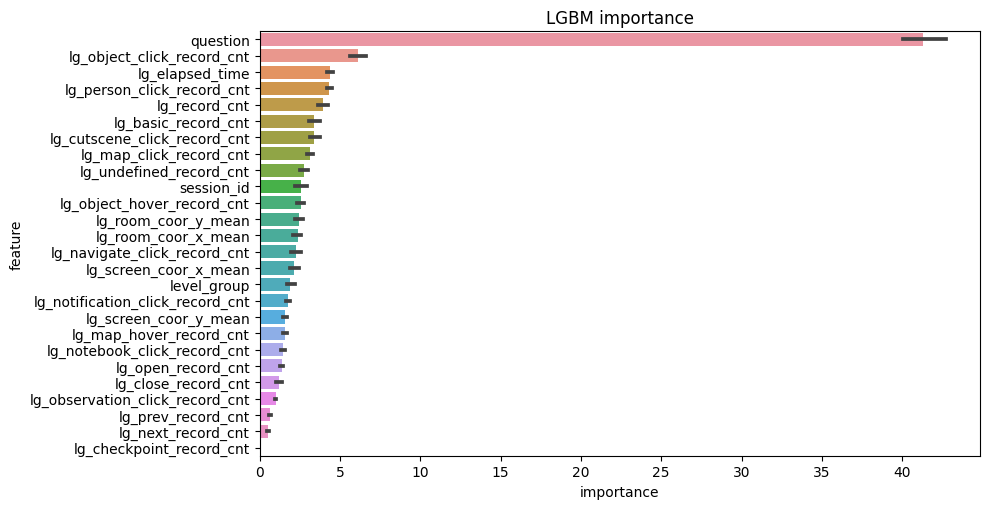

In [38]:
if cfg.mode == "local_cv":
    run_train()
#inference(cfg.mode)